In [ ]:
"""
Author: COMP90024 Group 32, 2024 May
    Yucheng Luo     <1153247>  <stluo@student.unimelb.edu.au>
    Yiyang Huang    <1084743>  <yiyahuang@student.unimelb.edu.au>
    Jiaqi Fan       <1266359>  <jffan2@student.unimelb.edu.au>
    Yingying Zhong  <1158586>  <yizhong1@student.unimelb.edu.au>
    Mingyao Ke      <1240745>  <mingyaok@student.unimelb.edu.au>
"""

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import folium
from folium.plugins import HeatMap
import numpy as np
import requests
import json
import warnings
warnings.filterwarnings('ignore')

In [30]:
OBJECT_ROOT = 'https://object-store.rc.nectar.org.au/v1/AUTH_cee2b7b252db404282a2beb9fb689e86/cloud-volume'
ROOT = "http://localhost:9099/"

In [3]:

def percentage_bar(df_visual):
    df_visual = df_visual.sort_values(by="percentage", ascending=False)
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x="percentage", y="sa2_name", data=df_visual, palette="viridis")
    ax.tick_params(axis='y', labelsize=8, labelrotation = 20)
    ax.set_title(f"Percentage of {reversed_illness_map[df_visual["illness"][0]]} by Region", fontsize=16)
    ax.set_xlabel("Percentage", fontsize=14)
    ax.set_ylabel("Region", fontsize=14)
    plt.show()
    
def count_bar(df_visual):
    df_visual = df_visual.sort_values(by="count", ascending=False)    
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x="count", y="sa2_name", data=df_visual, palette="viridis")
    ax.tick_params(axis='y', labelsize=8, labelrotation = 20)
    ax.set_title(f"Count of {reversed_illness_map[df_visual["illness"][0]]} by Region", fontsize=16)
    ax.set_xlabel("Count", fontsize=14)
    ax.set_ylabel("Region", fontsize=14)
    plt.show()
    
 
def percentage_map(df_visual):
    df_visual = df_visual.sort_values(by="percentage", ascending=False)
    melbourne_center = [-37.8136, 144.9631]
    m = folium.Map(location=melbourne_center, zoom_start=14)
    heat_data = [[row['lat'], row['lon'], row['percentage']] for index, row in df_visual.iterrows()]
    HeatMap(heat_data).add_to(m)
    return m
    
    
def count_map(df_visual):
    df_visual = df_visual.sort_values(by="count", ascending=False)
    melbourne_center = [-37.8136, 144.9631]
    m = folium.Map(location=melbourne_center, zoom_start=14)
    heat_data = [[row['lat'], row['lon'], row['count']] for index, row in df_visual.iterrows()]
    HeatMap(heat_data).add_to(m)
    return m
    
 
def area_percentage_bar(df_visual):
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x="percentage", y="illness", data=df_visual, palette="viridis")
    ax.tick_params(axis='y', labelsize=8, labelrotation = 20)
    ax.set_title(f"Percentage of each illness in {df_visual["sa2_name"][0]}", fontsize=16)
    ax.set_xlabel("Percentage", fontsize=14)
    ax.set_ylabel("Region", fontsize=14)
    plt.show() 
 
    
def area_count_bar(df_visual):
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x="count", y="illness", data=df_visual, palette="viridis")
    ax.tick_params(axis='y', labelsize=8, labelrotation = 20)
    ax.set_title(f"Number of each illness in {df_visual["sa2_name"][0]}", fontsize=16)
    ax.set_xlabel("Number", fontsize=14)
    ax.set_ylabel("Region", fontsize=14)
    plt.show()    
        
    
# gdf = pd.DataFrame(requests.get(f"{OBJECT_ROOT}/All_SA2.json").json())
gdf = pd.read_json(f"{OBJECT_ROOT}/All_SA2.json")
def json_to_df(jsf):
    data = []
    for obj in jsf:
        row = {
            "_id": obj["_id"],
            "sa2_code": obj['_source']["sa2_code"], 
            "sa2_name": obj['_source']["sa2_name"], 
            "illness": obj['_source']["illness"], 
            "count": obj['_source']["count"], 
            "tot_people": obj['_source']["tot_people"], 
            "percentage": obj['_source']["percentage"]
               }
        data.append(row)
    df = pd.DataFrame(data)
    df = pd.merge(df, gdf,left_on=['sa2_name', 'sa2_code'], right_on=['sa2_name', 'sa2_code'], how='inner')
    return df    

def split_features(df):
    weather = []
    income = []
    language = []
    for _, row in df.iterrows():
        if row[0][-3:] == "tot":
            row[0] = reversed_income_map[row[0]]
            income.append(row)
        elif row[0][-2:] == "_p":
            row[0] = reversed_language_map[row[0]]
            language.append(row)
        else:
            row[0] = reversed_weather_map[row[0]]
            weather.append(row)
    return pd.DataFrame(weather).reset_index(), pd.DataFrame(income).reset_index(), pd.DataFrame(language).reset_index()
    
illness_map = {
    "Other Long-Term Health Conditions": " a_oth_lthc_age_tot",
    "Arthritis": " arthritis_age_tot",
    "Asthma": " asthma_age_tot",
    "Cancer (including remission)": " cancer_inc_rem_age_tot",
    "Dementia (including Alzheimer's)": " dem_inc_alz_age_tot",
    "Diabetes (excluding gestational diabetes)": " dia_exc_ges_dia_age_tot",
    "Heart Disease (including heart attack and angina)": " hd_inc_ha_ang_age_tot",
    "Kidney Disease": " kid_dis_age_tot",
    "Lung Conditions (including COPD and emphysema)": " lc_inc_copd_emph_age_tot",
    "Mental Health Conditions (including depression and anxiety)": " mhc_inc_dep_anx_age_tot",
    "No Long-Term Health Conditions": " no_lthc_age_tot",
    "Not Stated": " not_st_age_tot",
    "Stroke": " stroke_age_tot"
}

reversed_illness_map = {v: k for k, v in illness_map.items()}

weekly_income_map = {
  "Nil income": " neg_nil_inc_tot",
  "Between 1 and 149": " _1_149_tot",
  "Between 150 and 299": " _150_299_tot",
  "Between 300 and 399": " _300_399_tot",
  "Between 400 and 499": " _400_499_tot",
  "Between 500 and 649": " _500_649_tot",
  "Between 650 and 799": " _650_799_tot",
  "Between 800 and 999": " _800_999_tot",
  "Between 1000 and 1249": " _1000_1249_tot",
  "Between 1250 and 1499": " _1250_1499_tot",
  "Between 1500 and 1749": " _1500_1749_tot",
  "Between 1750 and 1999": " _1750_1999_tot",
  "Between 2000 and 2499": " _2000_2499_tot",
  "Between 2500 and 2999": " _2500_2999_tot",
  "Between 3000 and 3499": " _3000_3499_tot",
  "Between 3500 and 3999": " _3500_3999_tot",
  "4000 or more": " _4000ormore_tot",
  "Partially stated income": " part_inc_stated_tot",
  "Income not stated": " all_inc_ns_tot",
  "Total households": " tot_tot"
}

reversed_income_map = {v: k for k, v in weekly_income_map.items()}

language_map = {
    "English": " uses_eng_on_p",
    "Afrikaans": " uses_othr_lang_afrikaans_p",
    "Arabic": " uses_othr_lang_arabic_p",
    "Australian Indigenous Languages": " uses_othr_lang_aus_ind_lang_p",
    "Chinese languages Cantonese": " uses_othr_lan_chin_lan_cant_p",
    "Chinese languages Mandarin": " uses_othr_lan_chin_lan_mand_p",
    "Chinese languages Other": " uses_othr_lan_chin_lan_othr_p",
    "Chinese languages Total": " uses_othr_lan_chin_lan_tot_p",
    "Croatian": " uses_othr_lang_croatian_p",
    "French": " uses_othr_lang_french_p",
    "German": " uses_othr_lang_german_p",
    "Greek": " uses_othr_lang_greek_p",
    "Indo Aryan Languages Bengali": " us_oth_lan_indo_ary_lan_ben_p",
    "Indo Aryan Languages Gujarati": " us_oth_lan_indo_ary_lan_guj_p",
    "Indo Aryan Languages Hindi": " us_oth_lan_indo_ary_lan_hin_p",
    "Indo Aryan Languages Nepali": " us_oth_lan_indo_ary_lan_nep_p",
    "Indo Aryan Languages Punjabi": " us_oth_lan_ind_ary_lan_punj_p",
    "Indo Aryan Languages Sinhalese": " us_oth_lan_ind_ary_lan_sinh_p",
    "Indo Aryan Languages Urdu": " us_oth_lan_indo_ary_lan_urd_p",
    "Indo Aryan Languages Other": " us_oth_lan_indo_ary_lan_oth_p",
    "Indo Aryan Languages Total": " us_oth_lan_indo_ary_lan_tot_p",
    "Italian": " uses_othr_lang_italian_p",
    "Japanese": " uses_othr_lang_japanese_p",
    "Khmer": " uses_othr_lang_khmer_p",
    "Korean": " uses_othr_lang_korean_p",
    "Macedonian": " uses_othr_lang_macedonian_p",
    "Malayalam": " uses_othr_lang_malayalam_p",
    "Persian excluding Dari": " us_oth_lan_persian_ex_dari_p",
    "Polish": " uses_othr_lang_polish_p",
    "Portuguese": " uses_othr_lang_portugese_p",
    "Russian": " uses_othr_lang_russian_p",
    "Samoan": " uses_othr_lang_samoan_p",
    "Serbian": " uses_othr_lang_serbian_p",
    "Southeast Asian Austronesian Languages Filipino": " us_oth_la_se_as_au_la_fili_p",
    "Southeast Asian Austronesian Languages Indonesian": " us_oth_la_se_as_au_la_indo_p",
    "Southeast Asian Austronesian Languages Tagalog": " us_oth_la_se_as_au_la_tag_p",
    "Southeast Asian Austronesian Languages Other": " us_oth_la_se_as_au_la_oth_p",
    "Southeast Asian Austronesian Languages Total": " us_oth_la_se_as_au_la_tot_p",
    "Spanish": " uses_othr_lang_spanish_p",
    "Tamil": " uses_othr_lang_tamil_p",
    "Thai": " uses_othr_lang_thai_p",
    "Turkish": " uses_othr_lang_turkish_p",
    "Vietnamese": " uses_othr_lang_vietnamese_p",
    "Other Language": " uses_othr_lang_other_p",
    "Total Other Language Persons": " uses_othr_lang_tot_p",
    "Not stated": " lang_used_home_ns_p",
    "Overseas visitors": " os_visitors_p",
    "Total Persons": " tot_p"
}

reversed_language_map = {v: k for k, v in language_map.items()}


weather_map = {
    "Gust Speed (km/h)": "gust_kmh",
    "Apparent Temperature": "apparent_t",
    "Delta Temperature": "delta_t",
    "Air Temperature": "air_temp",
    "Pressure": "press",
    "Rain Trace": "rain_trace",
    "Relative Humidity": "rel_hum",
    "Visibility (km)": "vis_km",
    "Wind Speed (km/h)": "wind_spd_kmh"
}

reversed_weather_map = {v: k for k, v in weather_map.items()}


## Software System for Long-term Health Analysis - Big Data Analytics on the Cloud

This is the intuitive front-end interface of our cloud-based software system. Our system provides a thorough analysis over the health insights across various SA2 regions. All results displayed are based on our backend-embedded model, which makes predictions relying on our real-time collected data. Our model can be updated periodically in real-time according to predefined intervals or manually updated based on requirement.

_________________

#### **Update Model**: If you want to update the model now, press the following button. [*Need admin authority*]

<button style="background-color: #4CAF50; color: white; padding: 10px 20px; text-align: center; display: inline-block; border: none; border-radius: 4px; cursor: pointer;">Update</button>


In [28]:
response = requests.get(f"{ROOT}train_model").content

In [29]:
response

b'OK'

<!-- #### - The current result is last updated at : **Time**   -->

<div style="text-align: right">
<sup>It is set to update at 1st of each month</sup>
</div>

### **Live**
_________________
#### The Top k severe illness is as follows:

In [9]:
k = input()
data = requests.get(f'{ROOT}frequent_illness').json()
pd.DataFrame({"Top Severe Illness": [reversed_illness_map[data[i]] for i in range(int(k))]})

,Top Severe Illness
0,No Long-Term Health Conditions
1,Mental Health Conditions (including depression...
2,Asthma
3,Other Long-Term Health Conditions
4,Arthritis
5,Not Stated


#### The Least k severe illness is as follows:

In [10]:
k = int(input())
data = requests.get(f'{ROOT}least_frequent_illness').json()
pd.DataFrame({"Least Severe Illness": [reversed_illness_map[data[i]] for i in range(k)]})

,Least Severe Illness
0,Dementia (including Alzheimer's)
1,Kidney Disease
2,Stroke
3,Cancer (including remission)
4,Lung Conditions (including COPD and emphysema)
5,Heart Disease (including heart attack and angina)


#### The Top 3 healthy SA2 area is as follows:

In [11]:
data = requests.get(f'{ROOT}most_healthy').json()
pd.DataFrame({"Most Healthy SA2": data[:3]})

,Most Healthy SA2
0,Shepparton - South East
1,Mildura - South
2,Echuca


#### The Top 3 unhealthy SA2 area is as follows:

In [12]:
data = requests.get(f'{ROOT}least_healthy').json()
pd.DataFrame({"Least Healthy SA2": data[:3]})

,Least Healthy SA2
0,Wilsons Promontory
1,Alps - West
2,Gowanbrae


### **Interactive Display**
_________________


#### Which illness do you care the most? You can choose any one from the following table to investigate.

In [13]:
pd.DataFrame({'illness': illness_map.keys(), "Please type in": illness_map.values()})

,illness,Please type in
0,Other Long-Term Health Conditions,a_oth_lthc_age_tot
1,Arthritis,arthritis_age_tot
2,Asthma,asthma_age_tot
3,Cancer (including remission),cancer_inc_rem_age_tot
4,Dementia (including Alzheimer's),dem_inc_alz_age_tot
5,Diabetes (excluding gestational diabetes),dia_exc_ges_dia_age_tot
6,Heart Disease (including heart attack and angina),hd_inc_ha_ang_age_tot
7,Kidney Disease,kid_dis_age_tot
8,Lung Conditions (including COPD and emphysema),lc_inc_copd_emph_age_tot
9,Mental Health Conditions (including depression...,mhc_inc_dep_anx_age_tot


#### **Result Display**

In [14]:
# arthritis_age_tot
ill_name = input()
ill = json_to_df(requests.get(f"{ROOT}get_illness/{ill_name}").json())
# with open("local_ill.json", 'r') as f:
#     ill = json_to_df(json.load(f))
ill.sort_values(by="percentage", ascending = False)[["sa2_name", "count", "tot_people", "percentage"]]\
    .rename(columns={"sa2_name": "SA2 Area", "count": "Illed Count", "tot_people": "Total Residents", "percentage": "Percentage"}).head()

,SA2 Area,Illed Count,Total Residents,Percentage
24,Orbost,28.0,6739,0.004155
60,Shepparton - South East,60.0,16421,0.003654
56,Swan Hill,40.0,11277,0.003547
0,Corowa Surrounds,24.0,7123,0.003369
48,Nhill Region,23.0,6889,0.003339


#### **Visualization**

##### Here gives the barplot of the chosen illness by SA2 area, showing the distribution of the **Percentage** of residents sick of the illness in each area

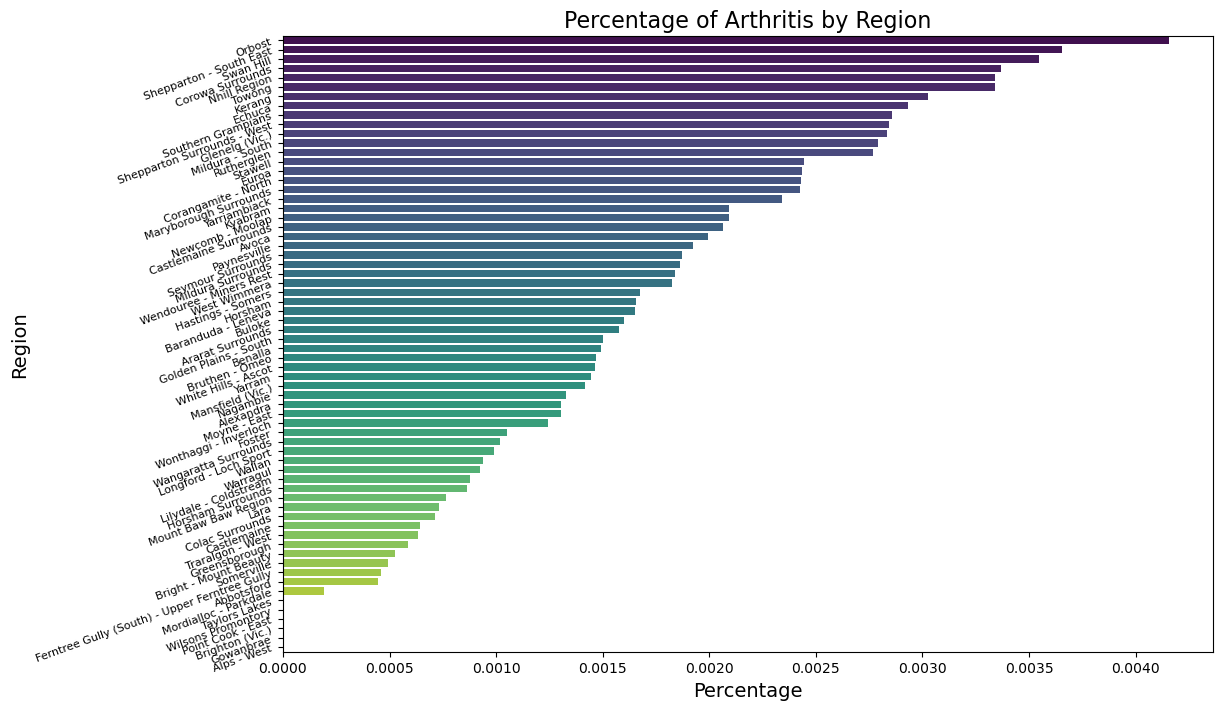

In [15]:
percentage_bar(ill)

##### Here gives the barplot of the chosen illness by SA2 area, showing the distribution of the **count** of residents sick of the illness in each area

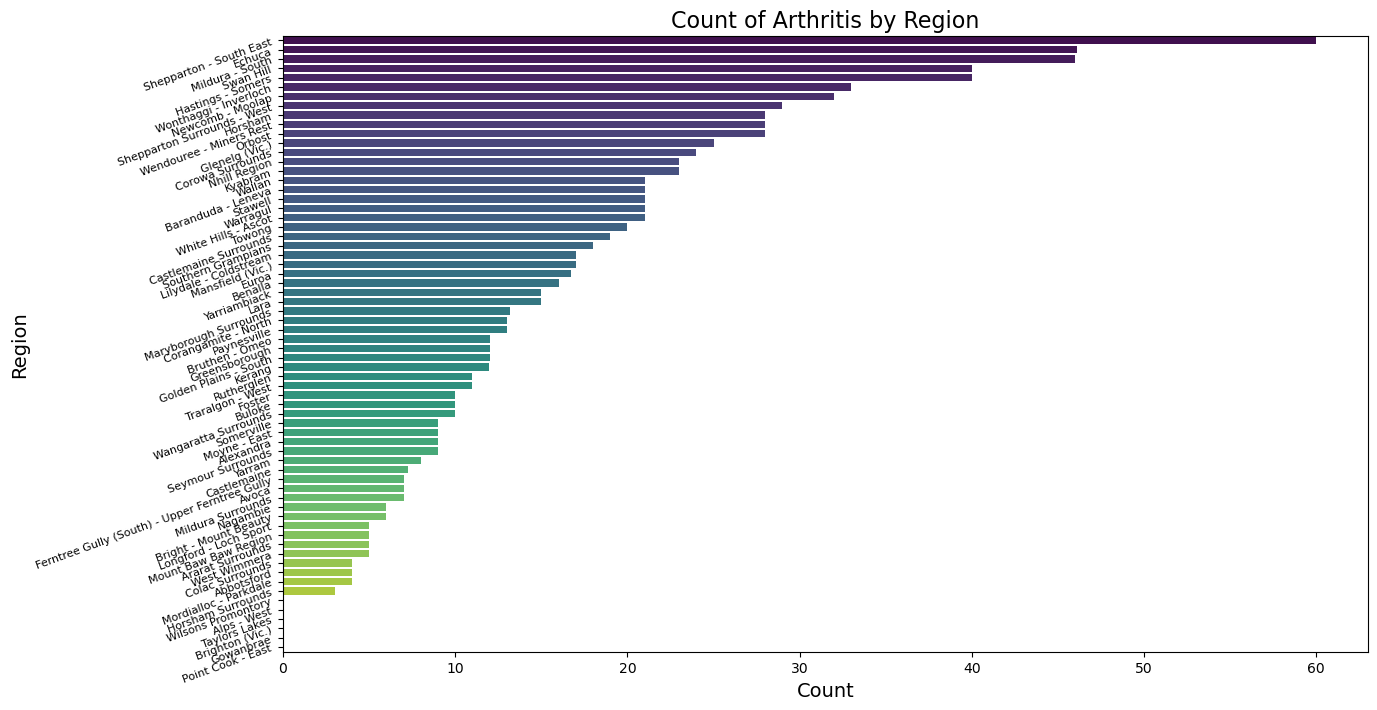

In [16]:
count_bar(ill)

##### Here gives the geography heatmap of the chosen illness by SA2 area, showing the distribution of the **percentage** of residents sick of the illness in each area

In [17]:
m = percentage_map(ill)
m

##### Here gives the geography heatrmap of the chosen illness by SA2 area, showing the distribution of the **count** of residents sick of the illness in each area

In [18]:
m = count_map(ill)
m

_________________
#### Which SA2 area do you care the most? You can type in the code any SA2 area within Victoria.

In [19]:
# code 109031181
sa2 = input()
area = json_to_df(requests.get(f"{ROOT}get_area/{sa2}").json())
# with open("local_area.json", 'r') as f:
#     area = json_to_df(json.load(f))
area["illness"] = area['illness'].map(reversed_illness_map)
area.sort_values(by="percentage", ascending = False)[["illness", "count", "tot_people", "percentage"]]\
    .rename(columns={"illness": "Illness", "count": "Illed Count", "tot_people": "Total Residents", "percentage": "Percentage"})


,Illness,Illed Count,Total Residents,Percentage
0,No Long-Term Health Conditions,68.0,7123,0.009547
10,Mental Health Conditions (including depression...,26.0,7123,0.003650
1,Arthritis,24.0,7123,0.003369
2,Asthma,22.0,7123,0.003089
11,Diabetes (excluding gestational diabetes),17.0,7123,0.002387
9,Other Long-Term Health Conditions,16.0,7123,0.002246
6,Not Stated,14.0,7123,0.001965
5,Heart Disease (including heart attack and angina),13.0,7123,0.001825
7,Cancer (including remission),4.0,7123,0.000562
12,Lung Conditions (including COPD and emphysema),4.0,7123,0.000562


#### **Result Display**

##### Here gives the barplot of the chosen SA2 area by each illness, showing the distribution of the **percentage** of residents sick of each illness in given area

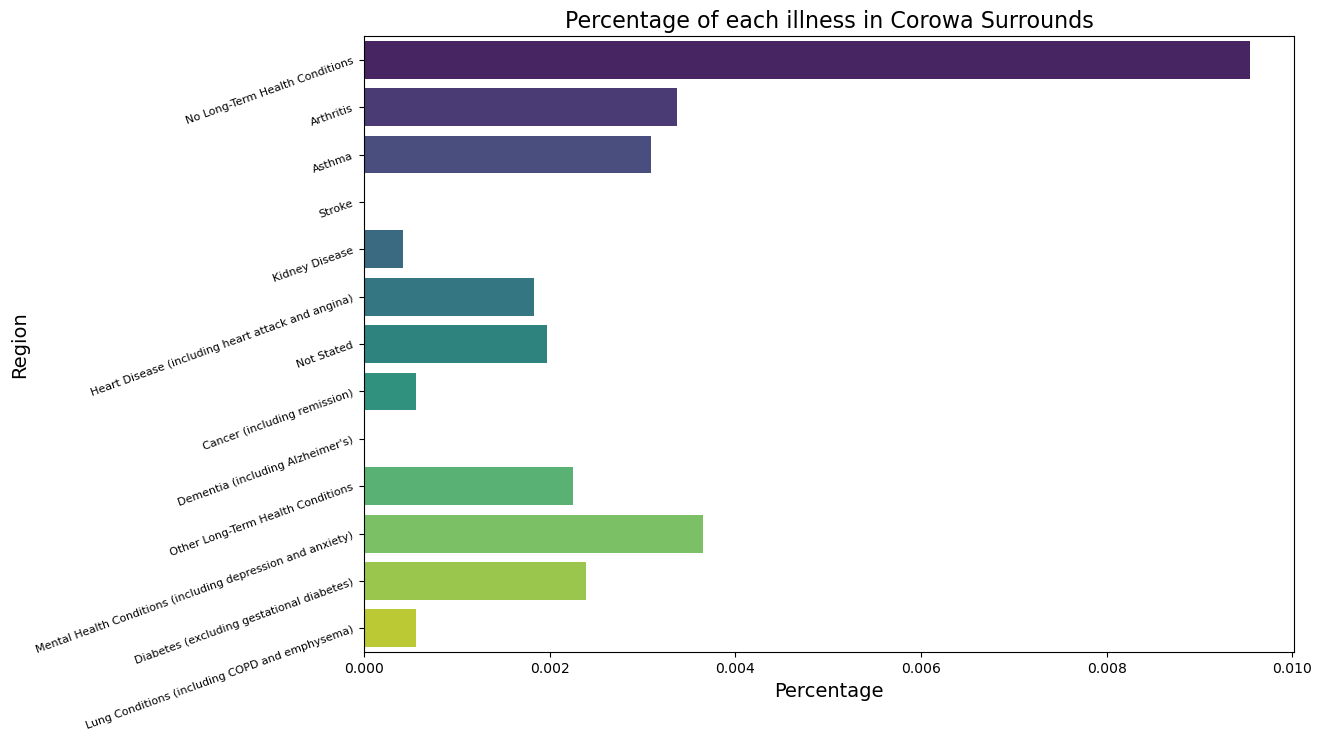

In [20]:
area_percentage_bar(area)

##### Here gives the barplot of the chosen SA2 area by each illness, showing the distribution of the **count** of residents sick of each illness in given area

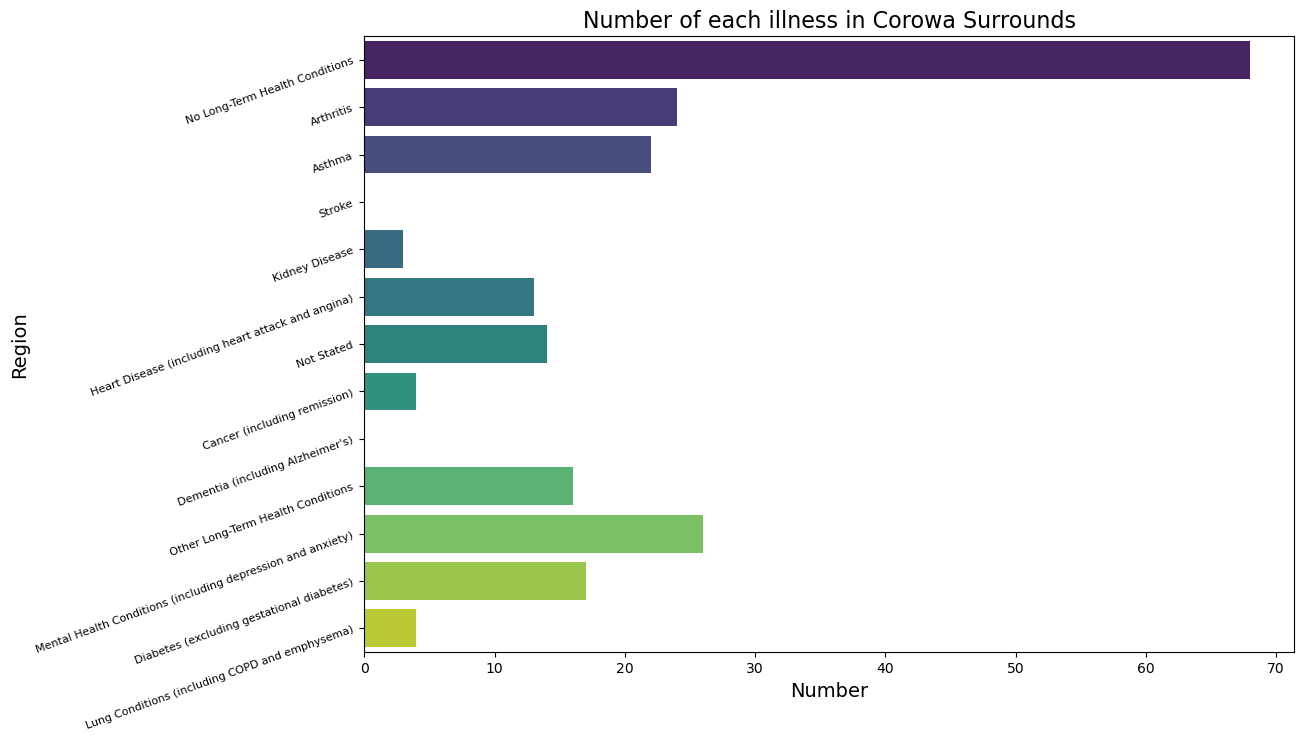

In [21]:
area_count_bar(area)

#### I want to see in which Areas that there are more than $p$ percentage of residents are now influenced by the illness

In [22]:
# arthritis_age_tot, 0.001
illness = input()
p = input()
area = requests.get(f"{ROOT}affected_percentage/{illness}/{p}").json()
pd.DataFrame({"SA2 Area": area.keys()})

,SA2 Area
0,Corowa Surrounds
1,Wendouree - Miners Rest
2,Avoca
3,Maryborough Surrounds
4,White Hills - Ascot
5,Castlemaine Surrounds
6,Golden Plains - South
7,Newcomb - Moolap
8,Alexandra
9,Euroa



### **Actual statistics**
_________________

##### Which SA2 area and illness do you want?

#### Result Display

In [23]:
#  109031181, asthma_age_tot
area = input()
illness = input()
data = json_to_df([requests.get(f"{ROOT}analysis/{area}/{illness}").json()])
data[["sa2_name", "illness", "count", "tot_people", "percentage"]]\
    .rename(columns={"sa2_name": "SA2 Name", "illness": "Illness", "count": "Illed Count", "tot_people": "Total Residents", "percentage": "Percentage"})

,SA2 Name,Illness,Illed Count,Total Residents,Percentage
0,Corowa Surrounds,asthma_age_tot,22.0,7123,0.003089



### **Insight Analysis**
_________________

##### Here we display the weight of influence of **Top K** factors from different aspects on your chosen **illness**. Results are based on our back-end embedded model
##### Factors are split into three categories:

- Weather Factors
- Socio-Economic Factors
- Racial and Cultural Customs Factors

In [24]:
# asthma_age_tot, 5
illness = input()
k = input()
features = pd.DataFrame(requests.get(f"{ROOT}get_importances/{illness}").json()[1:])
weather, income, language = split_features(features)

#### Results Display

##### The Top k important weather features influencing the illness are

In [25]:
pd.DataFrame({"Weather Feature": weather[0][:int(k)]})

,Weather Feature
0,Pressure
1,Visibility (km)
2,Delta Temperature
3,Gust Speed (km/h)
4,Apparent Temperature


##### The Top k level of income of the residents that are now influenced by the illness

In [26]:
pd.DataFrame({"Income Level": income[0][:int(k)]})

,Income Level
0,Between 650 and 799
1,Nil income
2,Income not stated
3,Between 1250 and 1499
4,Between 400 and 499


##### The Top k type of Cultural backgrounds of residents that are now influence by the illness

In [27]:
pd.DataFrame({"Cultural Custom": language[0][:int(k)]})

,Cultural Custom
0,Chinese languages Mandarin
1,Chinese languages Total
2,Afrikaans
3,Italian
4,Spanish
